In [3]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider
from datetime import datetime
today = int(datetime.today().strftime('%Y%m%d'))

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import cgi_phasec_poppy

import ray
if not ray.is_initialized():
    ray.init(log_to_driver=False)
    
from math_module import xp, ensure_np_array
import iefc_2dm 
import utils
from imshows import *

from emccd_detect import emccd_detect
meta_path = Path('/home/kianmilani/Projects/emccd_detect/emccd_detect/emccd_detect/util/metadata.yaml')

dm1_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm1.fits')
dm2_flat = fits.getdata(cgi_phasec_poppy.data_dir/'dm-acts'/'flatmaps'/'spc_wide_band4_flattened_dm2.fits')

data_dir = iefc_2dm.iefc_data_dir
response_dir = data_dir/'response-data'


In [1]:
20*4096/3600

22.755555555555556

1.3624486320346218e-17 sr
	Flux for wavelength 7.838e-07 m: 7.662e+08 ph / (s m2)
	Flux for wavelength 8.044e-07 m: 7.115e+08 ph / (s m2)
	Flux for wavelength 8.250e-07 m: 6.650e+08 ph / (s m2)
	Flux for wavelength 8.456e-07 m: 6.195e+08 ph / (s m2)
	Flux for wavelength 8.663e-07 m: 5.809e+08 ph / (s m2)
Total flux: 3.343e+09 ph / (s m2)


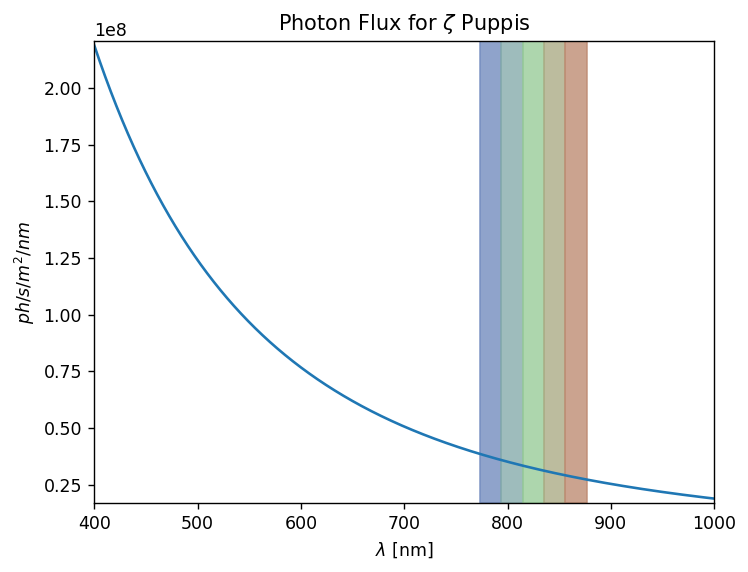

In [4]:
reload(cgi_phasec_poppy.source_flux)
wavelength_c = 825e-9*u.m

nwaves = 5
bandwidth = 10/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )

minlam = 400*u.nm
maxlam = 1000*u.nm
nlam = int((maxlam-minlam).value*20) + 1
lambdas = np.linspace(minlam, maxlam, nlam)

from astropy.constants import h, c, k_B, R_sun

zpup = cgi_phasec_poppy.source_flux.SOURCE(wavelengths=wavelengths,
                                            temp=40000*u.K,
                                            distance=300*u.parsec,
                                            diameter=2*14*R_sun,
                                            name='$\zeta$ Puppis', 
                                            lambdas=lambdas,
                                           )

zpup.plot_spectrum_ph()
source_fluxes = zpup.calc_fluxes()
total_flux = np.sum(source_fluxes)

for i,flux in enumerate(source_fluxes):
    print(f'\tFlux for wavelength {wavelengths[i]:.3e}: {flux:.3e}')
print(f'Total flux: {total_flux:.3e}')

In [5]:
reload(cgi_phasec_poppy.cgi)
reload(cgi_phasec_poppy.parallelized_cgi)

rayCGI = ray.remote(cgi_phasec_poppy.cgi.CGI) # make a ray actor class from the original CGI class  

kwargs = {
    'cgi_mode':'spc-wide',
    'npsf':150,
    'use_pupil_defocus':True,
    'use_opds':True,
    'polaxis':0,
}

actors = []
for i in range(nwaves):
    actors.append(rayCGI.options(num_cpus=4, num_gpus=1/5).remote(**kwargs))
    actors[i].setattr.remote('wavelength', wavelengths[i])
    actors[i].setattr.remote('source_flux', source_fluxes[i])

In [6]:
em_gain = 200
full_well_image = 60000.  # e-
full_well_serial = 100000.  # e-
#status=1,
dark_current = 8e-4  # e-/pix/s
cic = 0.01  # e-/pix/frame
read_noise = 120.  # e-/pix/frame
bias = 500.  # e-
qe = 0.5
cr_rate = 0.  # hits/cm^2/s
pixel_pitch = 13e-6  # m
eperdn = 1 #7.,
nbits = 16
numel_gain_register=604

emccd = emccd_detect.EMCCDDetect(em_gain=em_gain,
                                    full_well_image=full_well_image,  # e-
                                    full_well_serial=full_well_serial,  # e-
                                    #status=status,
                                    dark_current=dark_current,  # e-/pix/s
                                    cic=cic,  # e-/pix/frame
                                    read_noise=read_noise,  # e-/pix/frame
                                    bias=bias,  # e-
                                    qe=qe,
                                    cr_rate=cr_rate,  # hits/cm^2/s
                                    pixel_pitch=pixel_pitch,  # m
                                    eperdn=eperdn,
                                    nbits=nbits,
                                    numel_gain_register=numel_gain_register,
                                    meta_path=meta_path
                                    )

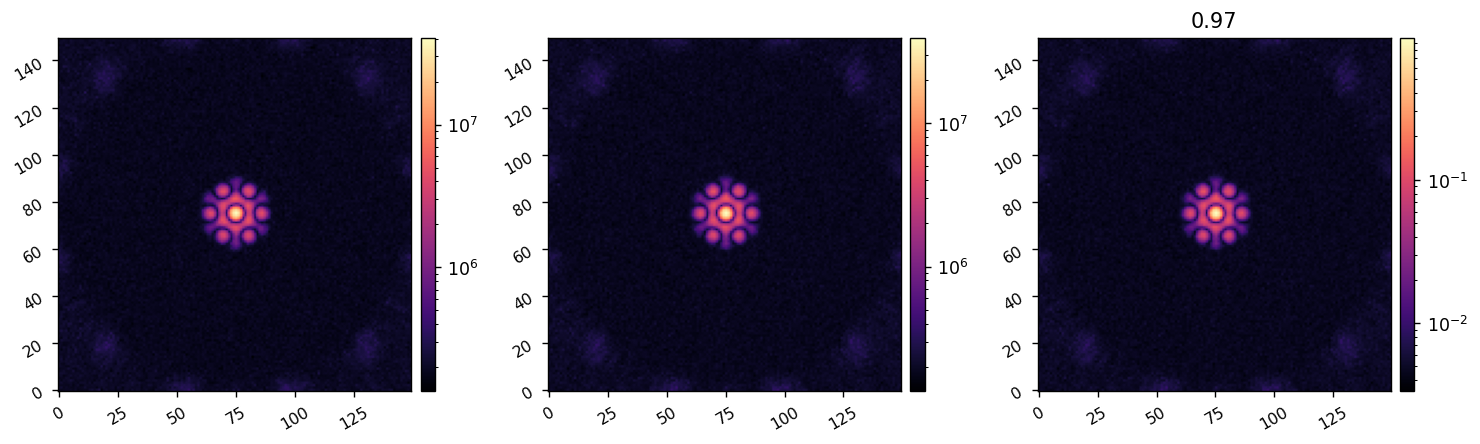

Computing each monochromatic image.
Generating all frames based on computed flux for exposure time 1/3
Generating all frames based on computed flux for exposure time 2/3
Generating all frames based on computed flux for exposure time 3/3


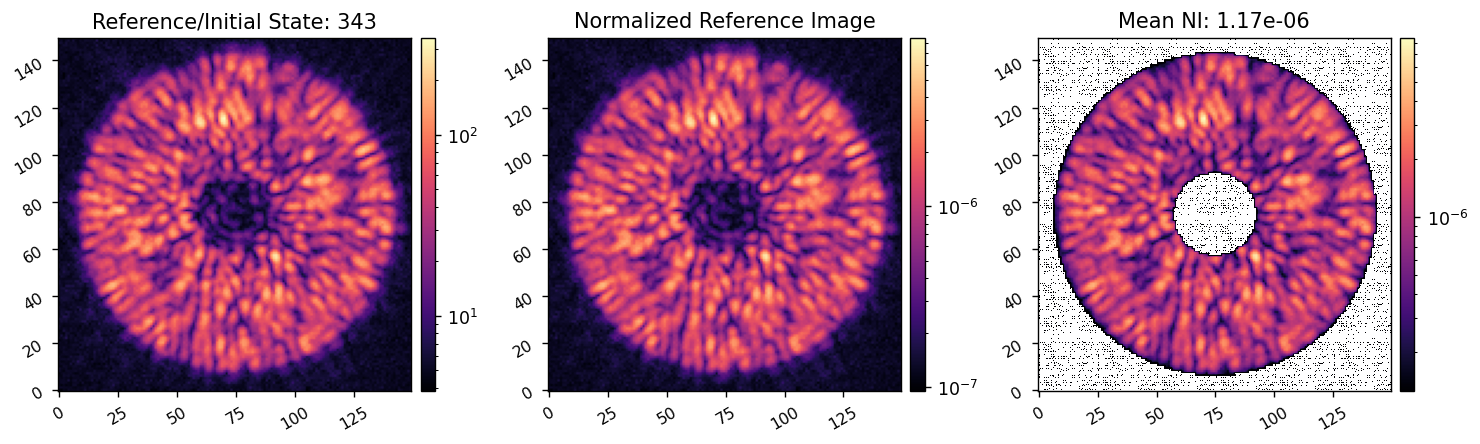

In [7]:
reload(cgi_phasec_poppy.parallelized_cgi)
mode = cgi_phasec_poppy.parallelized_cgi.ParallelizedCGI(actors=actors, 
                                                         dm1_ref=2*dm1_flat,
                                                        #  dm2_ref=dm2_flat,
                                                         )

mode.EMCCD = emccd

unocc_em_gain = 200

mode.set_actor_attr('use_fpm',False)
mode.Nframes = 10
mode.EMCCD.em_gain = unocc_em_gain

mode.exp_times_list = np.array([0.000005, 0.00005, 0.0005])

raw_im = mode.snap_many()

mode.normalize = True
mode.Imax_ref = xp.max(raw_im.max())
mode.em_gain_ref = unocc_em_gain

ref_unocc_im = mode.snap_many()
imshow3(raw_im, ref_unocc_im*mode.Imax_ref, ref_unocc_im, 
        '', '', f'{xp.max(ref_unocc_im):.2f}', lognorm=True,
        save_fig='test_normalization_image.png')

mode.EMCCD.em_gain = 200

mode.set_actor_attr('use_fpm',True)
mode.exp_times_list = [0.2,2,5]
mode.Nframes_list = [10, 4, 2]
ref_im = mode.snap_many(quiet=False,)

control_mask = utils.create_annular_focal_plane_mask(mode, inner_radius=5.4, outer_radius=20.6, edge=None)
mean_ni = xp.mean(ref_im[control_mask])
imshow3(ref_im*mode.Imax_ref, ref_im, ref_im*control_mask, 
        f'Reference/Initial State: {xp.max(ref_im*mode.Imax_ref):.0f}', 
        'Normalized Reference Image',
        f'Mean NI: {mean_ni:.2e}',
        lognorm=True,)


In [12]:
mode


# Create calibration and probe modes

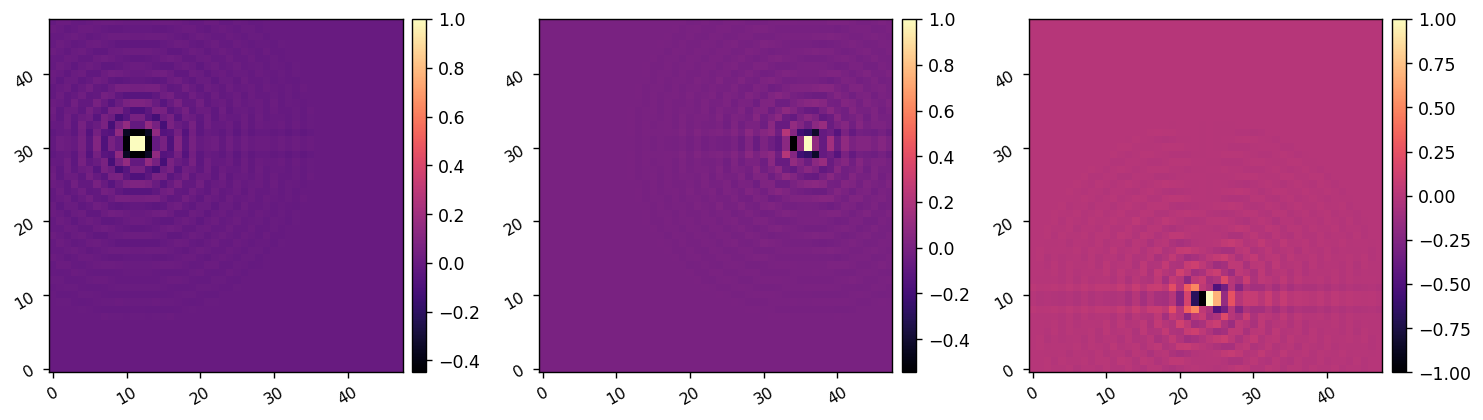

(4096, 4608)


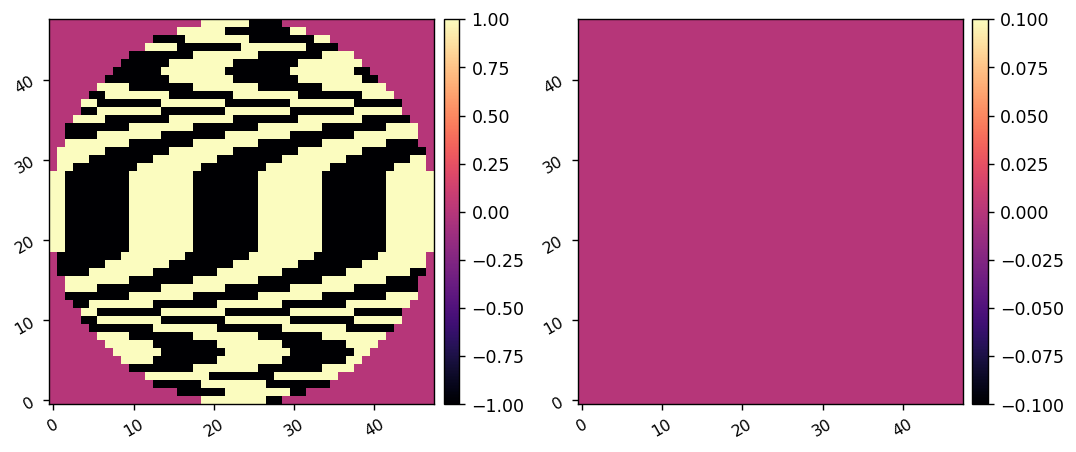

In [8]:
probe_modes = utils.create_fourier_probes(mode, control_mask, fourier_sampling=0.2,
                                          shift=[(-12,7), (12,7),(0,-14), (0,0)], nprobes=3,
                                           use_weighting=True)
imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

calib_modes = utils.create_hadamard_modes(mode.dm_mask, ndms=2)
Nmodes = calib_modes.shape[0]
print(calib_modes.shape)
i = 8
imshow2(calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact), calib_modes[i+mode.Nacts,mode.Nact**2:].reshape(mode.Nact,mode.Nact))



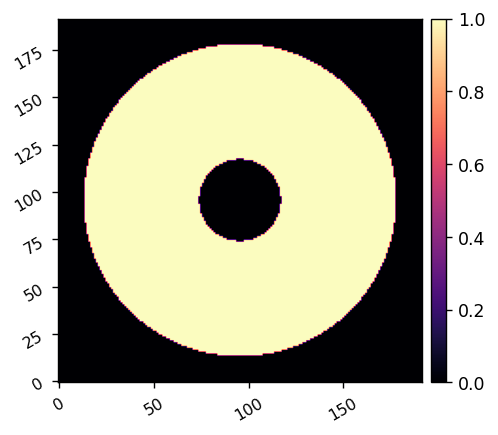

(4096,)


In [9]:
reload(utils)
oversamp = 4

had_modes = xp.array(calib_modes)
ft_modes = []
for i in range(calib_modes.shape[0]//2):
    had_mode = had_modes[i,:mode.Nact**2].reshape(mode.Nact, mode.Nact)
    ft_modes.append(xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(utils.pad_or_crop(had_mode, mode.Nact*oversamp)))))
mode_freqs = xp.abs(xp.array(ft_modes))**2

mode_freq_mask_pxscl = 1/oversamp
x = (xp.linspace(-mode.Nact*oversamp//2, mode.Nact*oversamp//2-1, mode.Nact*oversamp) + 1/2)*mode_freq_mask_pxscl
x,y = xp.meshgrid(x,x)
r = xp.sqrt(x**2+y**2)
mode_freq_mask = (r>5.4)*(r<20.6)
imshow1(mode_freq_mask)

sum_vals = []
max_vals = []
for i in range(calib_modes.shape[0]//2):
    sum_vals.append(xp.sum(mode_freqs[i, mode_freq_mask]))
    max_vals.append(xp.max(mode_freqs[i, mode_freq_mask]))

biggest_sum = xp.max(xp.array(sum_vals))
biggest_max = xp.max(xp.array(max_vals))

scale_factors = []
for i in range(calib_modes.shape[0]//2):
    scale_factors.append((biggest_max/max_vals[i])**(1/3))
    # scale_factors.append(xp.exp(-(biggest_max/max_vals[i]-1)))
scale_factors = ensure_np_array(xp.array(scale_factors))
# scale_factors[scale_factors>2] = 2
# scale_factors[scale_factors<1/2] = 1/2

scale_factors = np.concatenate([scale_factors,scale_factors])
print(scale_factors.shape)

In [21]:
0.005*10

0.05

In [23]:
mode.exp_times_list = np.array([0.01/2, 0.01, 0.1])
mode.Nframes_list = np.array([10, 5, 4])

total_exp_time = np.sum(mode.exp_times_list*mode.Nframes_list)
print(f'Total exposure time: {total_exp_time:.2f}s')


Total exposure time: 0.50s


Total exposure time: 0.50s


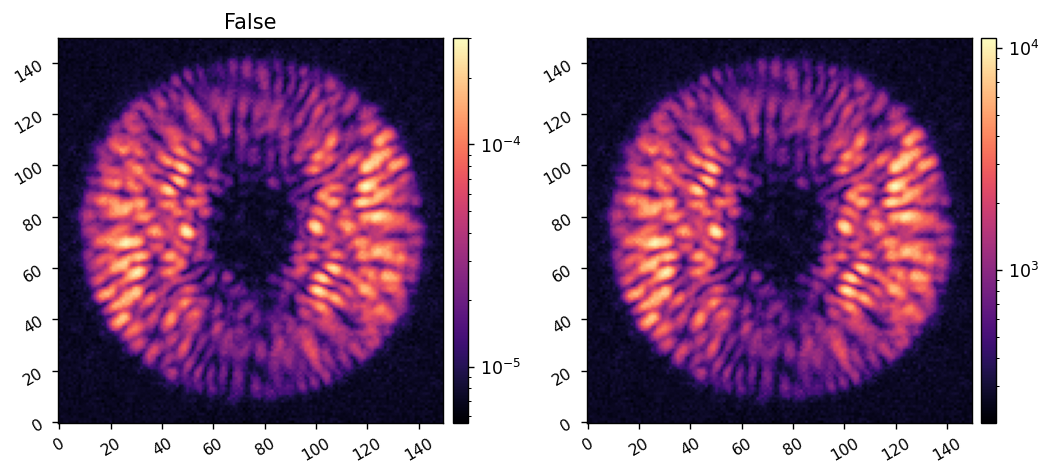

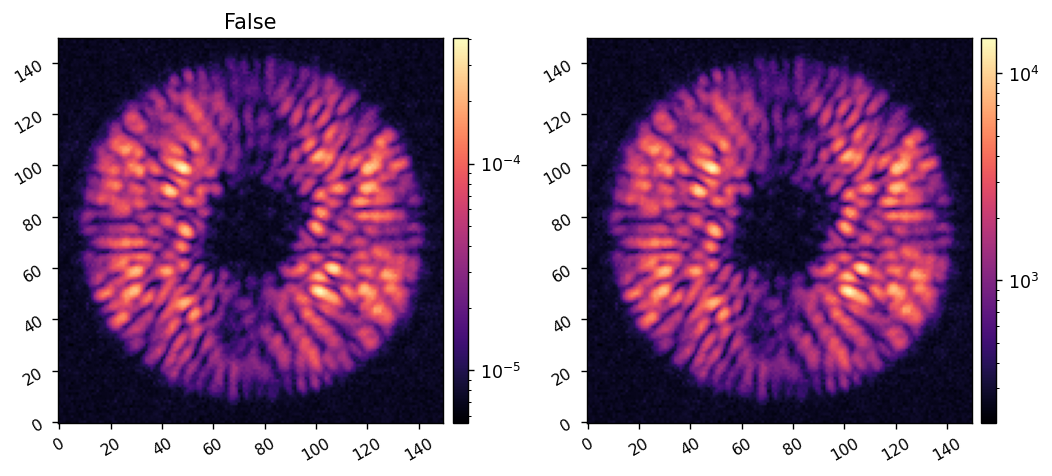

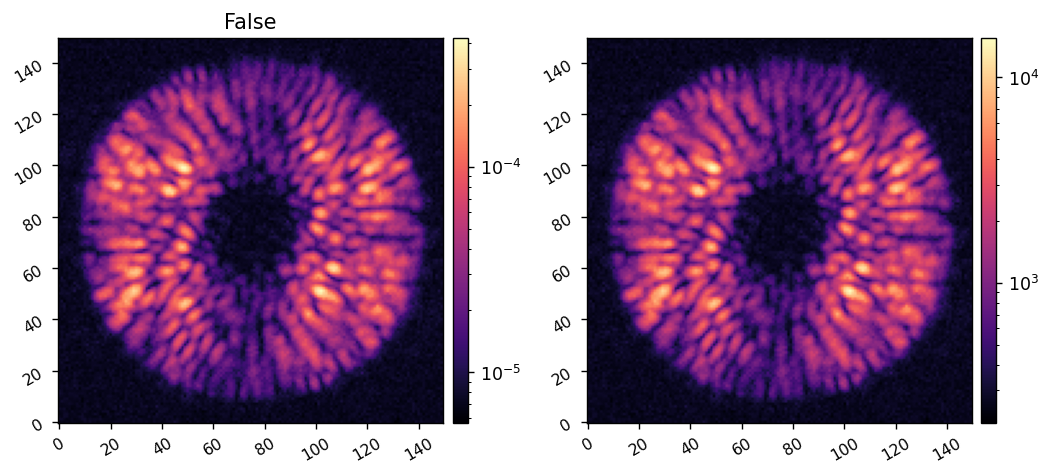

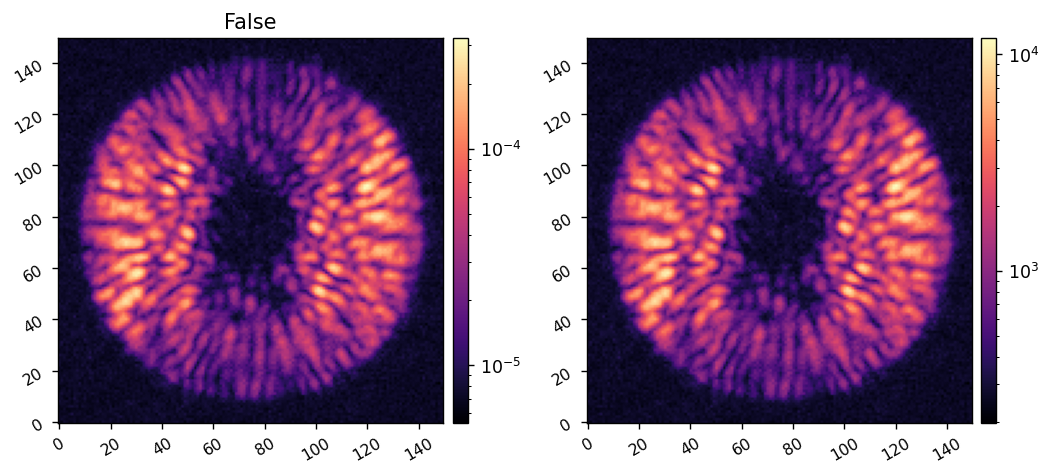

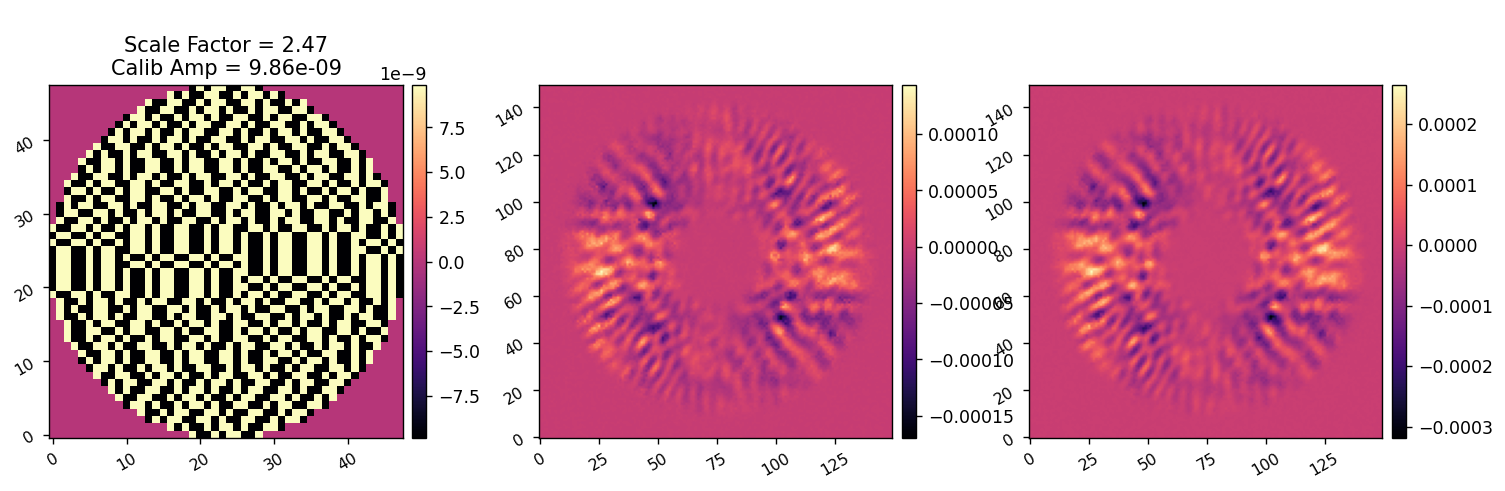

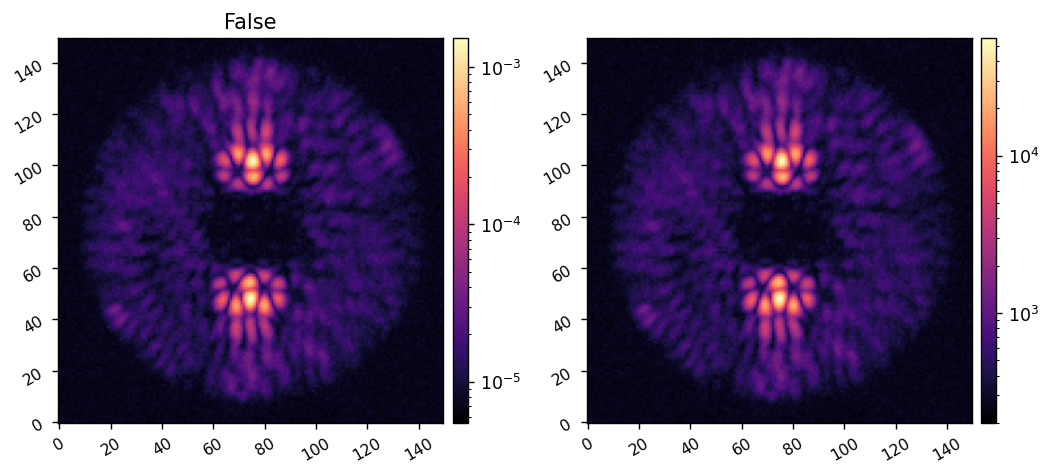

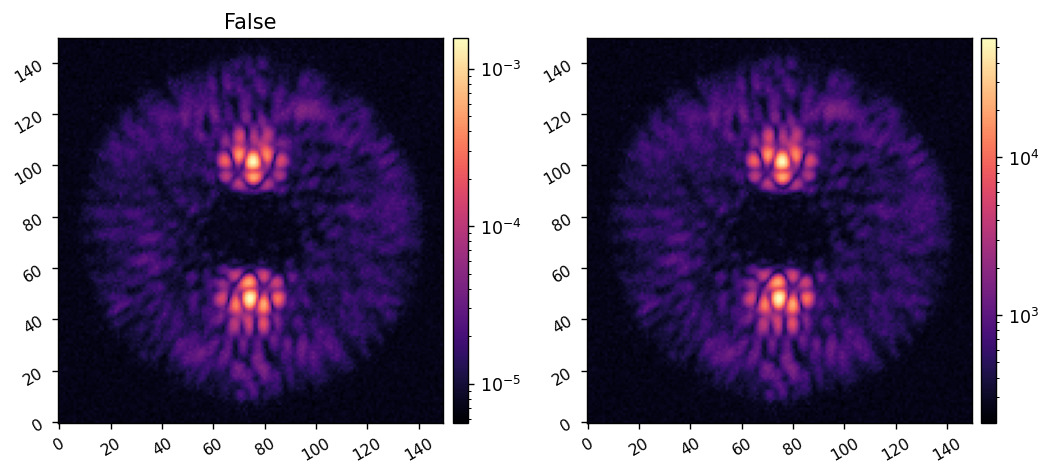

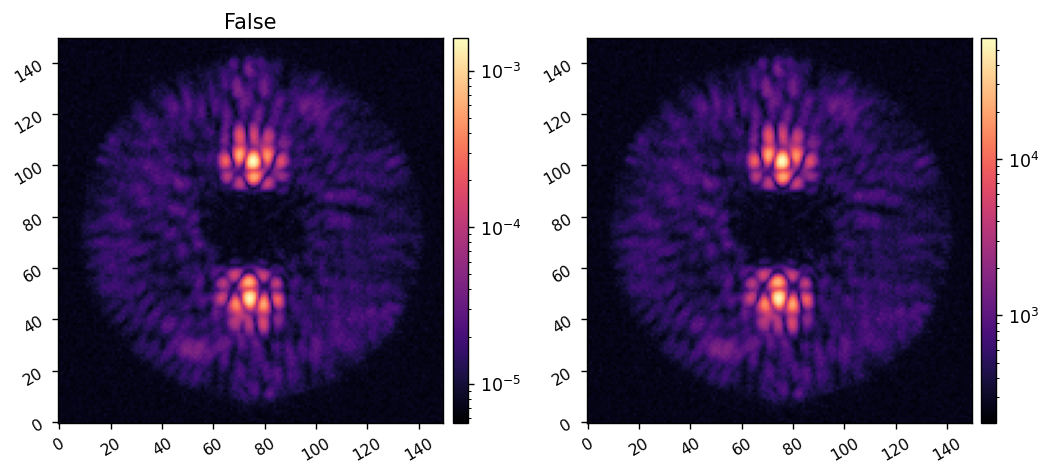

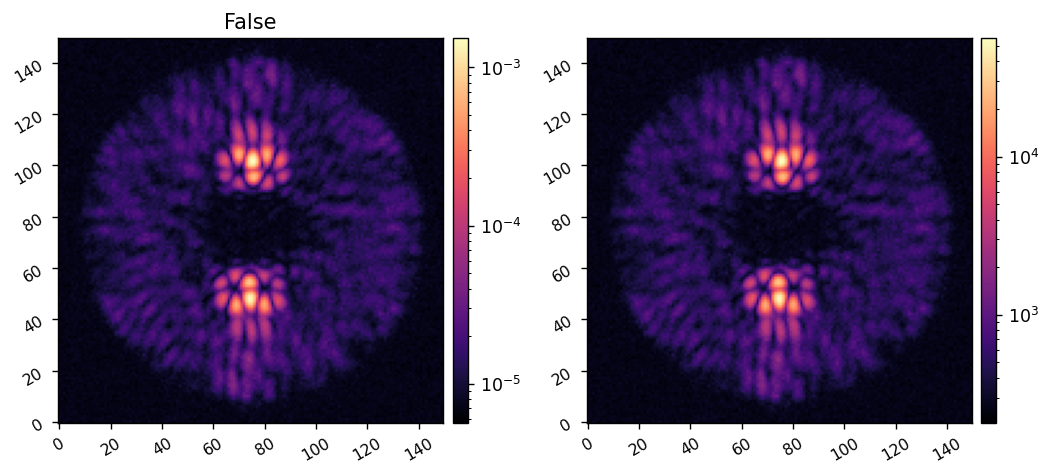

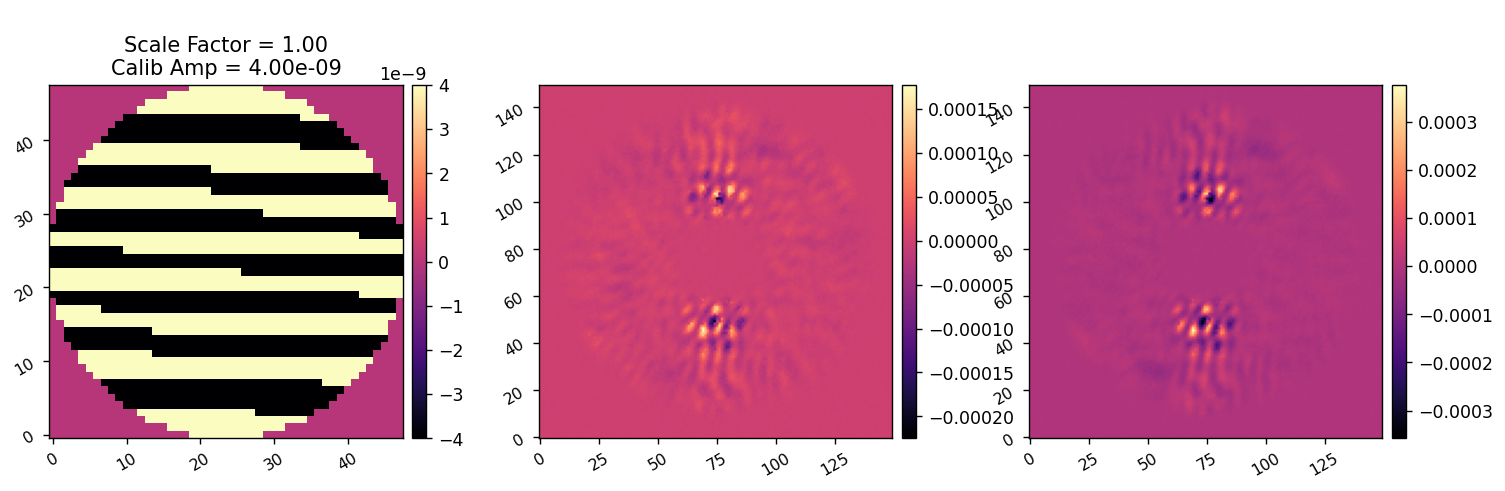

In [30]:
mode.normalize = True
mode.reset_dms()

# mode.EMCCD.em_gain = 500
# mode.gain_list = [150, 750, 750]
mode.gain_list = [200]*3
mode.exp_times_list = np.array([0.01/2, 0.01, 0.1])
mode.Nframes_list = np.array([10, 5, 4])

total_exp_time = np.sum(mode.exp_times_list*mode.Nframes_list)
print(f'Total exposure time: {total_exp_time:.2f}s')

calib_amp = 4e-9
probe_amp = 20e-9

for i in range(191, 193):
        dm_mode = calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact)
        scaled_calib_amp = calib_amp * scale_factors[i]
        # print(scale_factors[i], scaled_calib_amp)

        # mode.add_dm1(scaled_calib_amp*dm_mode)
        # mode.add_dm1(probe_amp*probe_modes[0])
        # im1 = mode.snap()
        # mode.add_dm1(-probe_amp*probe_modes[0])
        # mode.add_dm1(-scaled_calib_amp*dm_mode)

        mode.add_dm1(scaled_calib_amp*dm_mode)
        mode.add_dm1(probe_amp*probe_modes[0])
        im1 = mode.snap_many()
        mode.add_dm1(-probe_amp*probe_modes[0])
        imshow2(im1, im1*mode.Imax_ref, f'{xp.max(xp.isnan(im1))}', lognorm=True)

        mode.add_dm1(-probe_amp*probe_modes[0])
        im2 = mode.snap_many()
        mode.add_dm1(probe_amp*probe_modes[0])
        mode.add_dm1(-scaled_calib_amp*dm_mode)
        imshow2(im2, im2*mode.Imax_ref, f'{xp.max(xp.isnan(im2))}', lognorm=True)
        
        mode.add_dm1(-scaled_calib_amp*dm_mode)
        mode.add_dm1(probe_amp*probe_modes[0])
        im3 = mode.snap_many()
        mode.add_dm1(-probe_amp*probe_modes[0])
        imshow2(im3, im3*mode.Imax_ref, f'{xp.max(xp.isnan(im3))}', lognorm=True)

        mode.add_dm1(-probe_amp*probe_modes[0])
        im4 = mode.snap_many()
        mode.add_dm1(probe_amp*probe_modes[0])
        mode.add_dm1(scaled_calib_amp*dm_mode)
        imshow2(im4, im4*mode.Imax_ref, f'{xp.max(xp.isnan(im4))}', lognorm=True)

        diff_im1 = im1 - im2
        diff_im2 = im3-im4

        imshow3(scaled_calib_amp*dm_mode, diff_im1, diff_im1 - diff_im2,
                f'\nScale Factor = {scale_factors[i]:.2f}\nCalib Amp = {scaled_calib_amp:.2e}', 
                )

In [ ]:
reload(iefc_2dm)
mode.normalize = True

i = 190

calib_amp = 5e-9
probe_amp = 20e-9

dm_mode = calib_modes[i,:mode.Nact**2].reshape(mode.Nact,mode.Nact)

mode.add_dm1(calib_amp* dm_mode)
differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
diff_ims1 = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
mode.add_dm1(-calib_amp*dm_mode)
imshow3(diff_ims1[0], diff_ims1[1], diff_ims1[2])

mode.add_dm1(-calib_amp* dm_mode)
differential_images, single_images = iefc_2dm.take_measurement(mode, probe_modes, probe_amp, return_all=True, plot=True)
diff_ims2 = differential_images.reshape(probe_modes.shape[0], mode.npsf, mode.npsf)
mode.add_dm1(+calib_amp*dm_mode)
imshow3(diff_ims1[0], diff_ims1[1], diff_ims1[2])

responses = 2*calib_amp*(diff_ims1-diff_ims2)
imshow3(responses[0], responses[1], responses[2])




In [9]:
17.7*4096/3600

20.138666666666666

Calibrating iEFC...
	Calibrated mode 1/3 in 20.651s
	Calibrated mode 2/3 in 40.495s
	Calibrated mode 3/3 in 60.322s

Calibration complete.


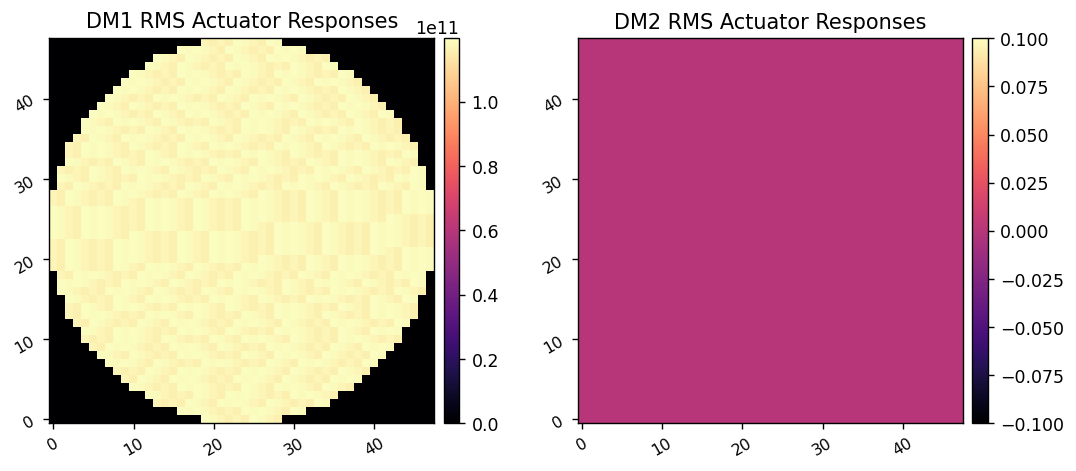

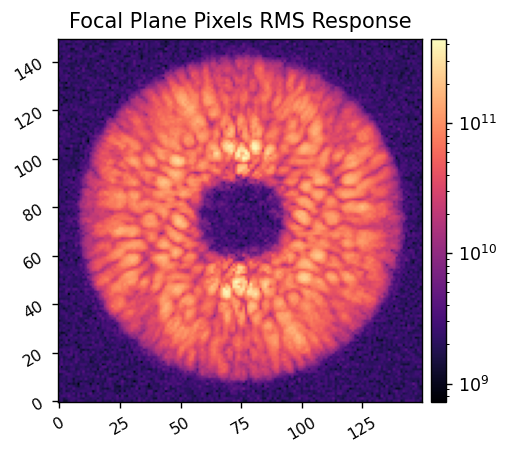

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/test_response_matrix_20240212.fits


In [29]:
reload(iefc_2dm)

mode.reset_dms()
# mode.exp_times_list = None

calib_amp = 5e-9
probe_amp = 20e-9

response_matrix, response_cube, calib_amps = iefc_2dm.calibrate(mode, 
                                                    control_mask,
                                                    probe_amp, probe_modes, 
                                                     calib_amp, calib_modes[190:193], 
                                                     return_all=True, 
#                                                     plot_responses=False,
                                                   )

utils.save_fits(response_dir/f'test_response_matrix_{today}.fits', response_matrix)
# utils.save_fits(response_dir/f'test_response_cube_{today}.fits', response_cube)


In [15]:

date = 20240211

response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_band4_had_modes_response_matrix_{date}.fits'))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4096                                                  
NAXIS2  =                40572                                                  
EM_GAIN =                  500                                                  

7407274252188.097


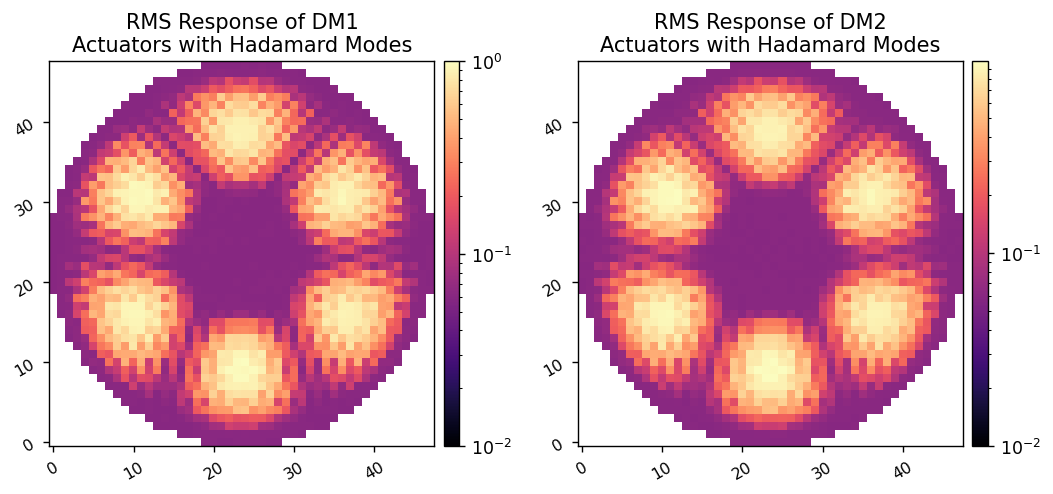

In [11]:
date = 20240212

response_matrix = xp.array(fits.getdata(response_dir/f'spc_wide_band4_emccd_response_matrix_{date}.fits'))

dm_response = xp.sqrt(xp.mean(response_matrix.dot(xp.array(calib_modes))**2, axis=0))
dm1_response = dm_response[:mode.Nact**2].reshape(mode.Nact, mode.Nact)/dm_response.max()
dm2_response = dm_response[mode.Nact**2:].reshape(mode.Nact, mode.Nact)/dm_response.max()

print(dm_response.max())
imshow2(dm1_response, dm2_response, 
        'RMS Response of DM1\nActuators with Hadamard Modes', 'RMS Response of DM2\nActuators with Hadamard Modes',
        lognorm=True, vmin1=0.01, vmin2=0.01,
        )


In [115]:
nwaves = 3
bandwidth = 2.9/100
minwave = wavelength_c * (1 - bandwidth/2)
maxwave = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minwave, maxwave, nwaves )
wavelengths

<Quantity [8.130375e-07, 8.250000e-07, 8.369625e-07] m>

# Run IEFC

In [72]:
mode.reset_dms()
images = xp.array([ref_im])
dm1_commands = xp.array([mode.get_dm1()])
dm2_commands = xp.array([mode.get_dm2()])
regs = xp.array([])


300
Computing each monochromatic image.
Generating all frames based on computed flux for exposure time 1/3
Generating all frames based on computed flux for exposure time 2/3
Generating all frames based on computed flux for exposure time 3/3


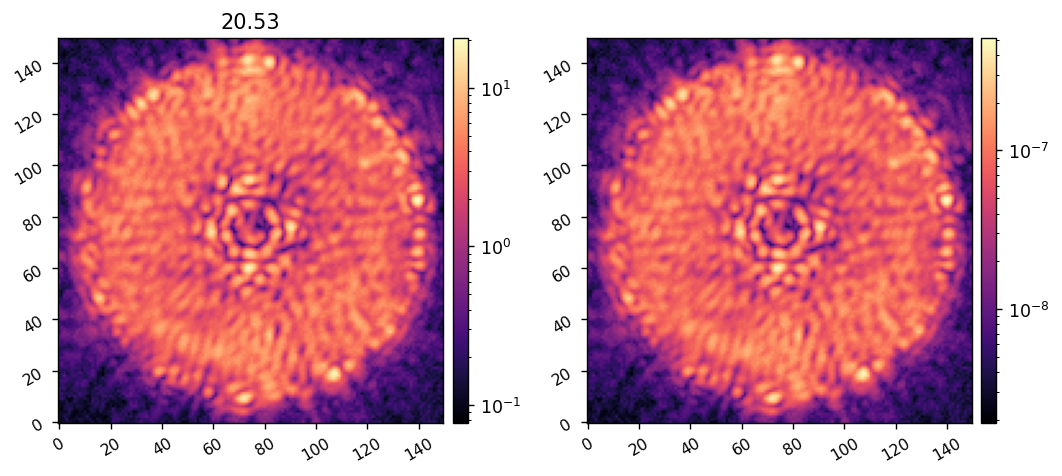

In [103]:
probe_exp_times = np.array([10, 30, 60])
probe_Nframes = np.array([6,4,2])
probe_em_gain = 300
probe_gain_list = np.array([probe_em_gain]*len(probe_exp_times))

total_exp_time = np.sum(probe_exp_times*probe_Nframes)
print(total_exp_time)

probe_amp = 2.5e-9

mode.exp_times_list = probe_exp_times
mode.gain_list = probe_gain_list
mode.Nframes_list = probe_Nframes
mode.EMCCD.em_gain = probe_em_gain

mode.subtract_bias = False
mode.add_dm1(probe_amp*probe_modes[0])
# im = mode.snap_many()
im = mode.snap_many(quiet=False,
                    # plot=True,
                    )
mode.add_dm1(-probe_amp*probe_modes[0])

imshow2(im*mode.Imax_ref, im, f'{xp.max(im*mode.Imax_ref):.2f}', lognorm=True,)

300
Computing each monochromatic image.
Generating all frames based on computed flux for exposure time 1/3
Generating all frames based on computed flux for exposure time 2/3
Generating all frames based on computed flux for exposure time 3/3


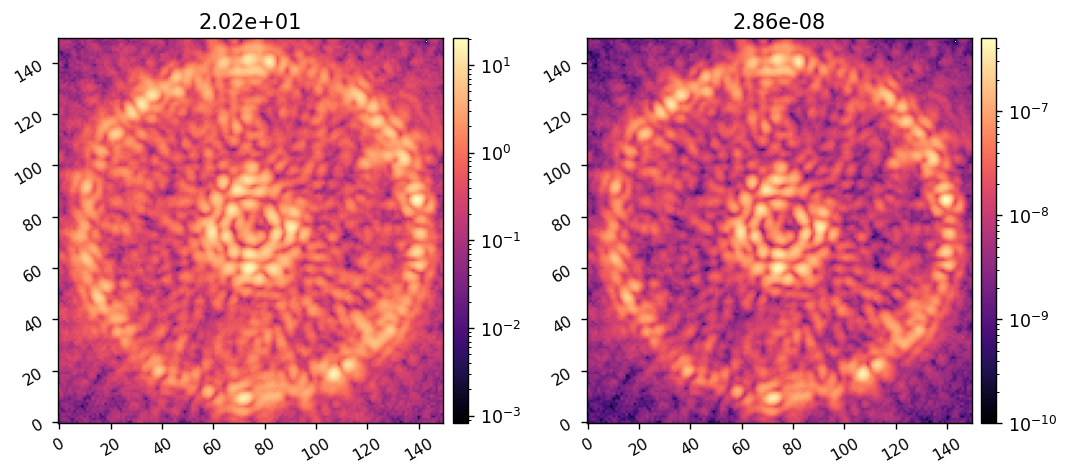

In [102]:
metric_exp_times = np.array([10,30,60])
metric_Nframes = np.array([6,4,2])
metric_em_gain = 300
metric_gain_list = np.array([metric_em_gain]*len(metric_exp_times))

total_exp_time = np.sum(metric_exp_times*metric_Nframes)
print(total_exp_time)

mode.exp_times_list = metric_exp_times
mode.Nframes_list = metric_Nframes
mode.gain_list = metric_gain_list
# mode.EMCCD.em_gain = metric_em_gain

mode.subtract_bias = True
# im = mode.snap_many()
im = mode.snap_many(quiet=False,
                #     plot=True,
                    )

mean_ni = xp.mean(im[control_mask])
imshow2(im*mode.Imax_ref, im, 
        f'{xp.max(im*mode.Imax_ref):.2e}',
        f'{mean_ni:.2e}',
         lognorm=True, vmin2=1e-10)

Running iEFC...
	Closed-loop iteration 28 / 30
False
False


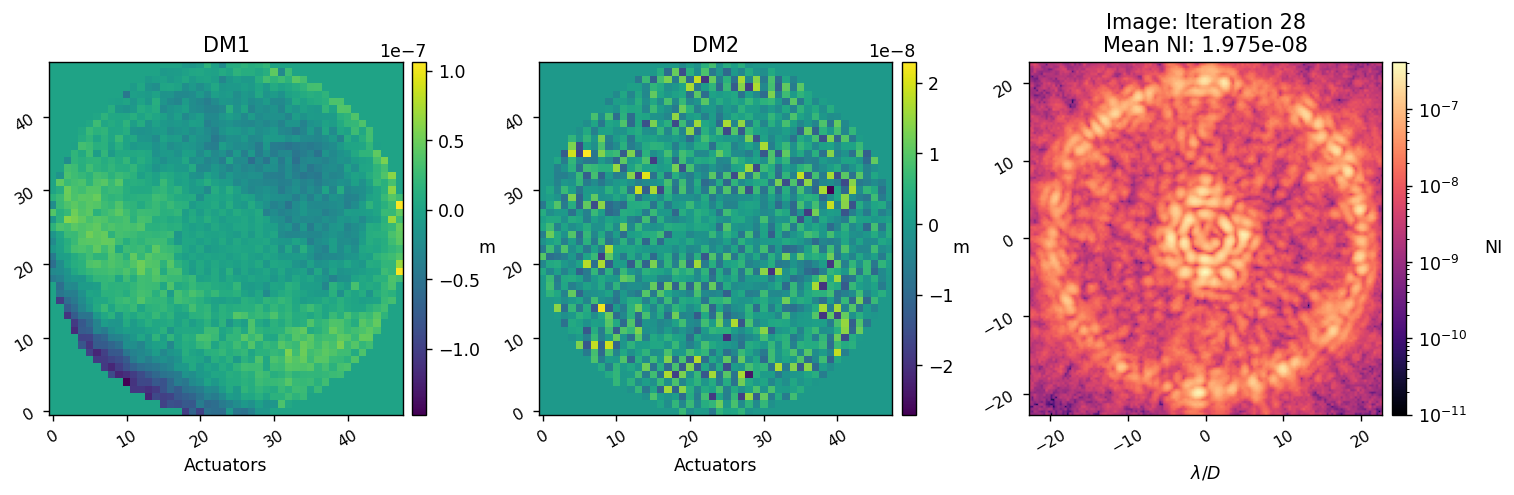

	Closed-loop iteration 29 / 30
False
False


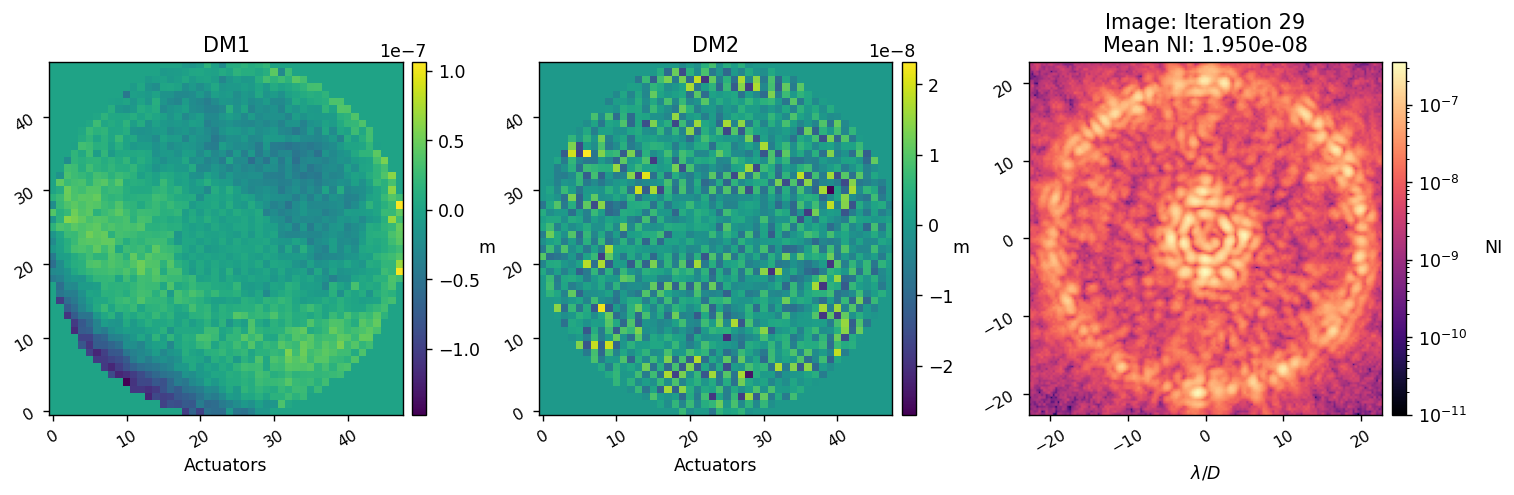

	Closed-loop iteration 30 / 30
False
False


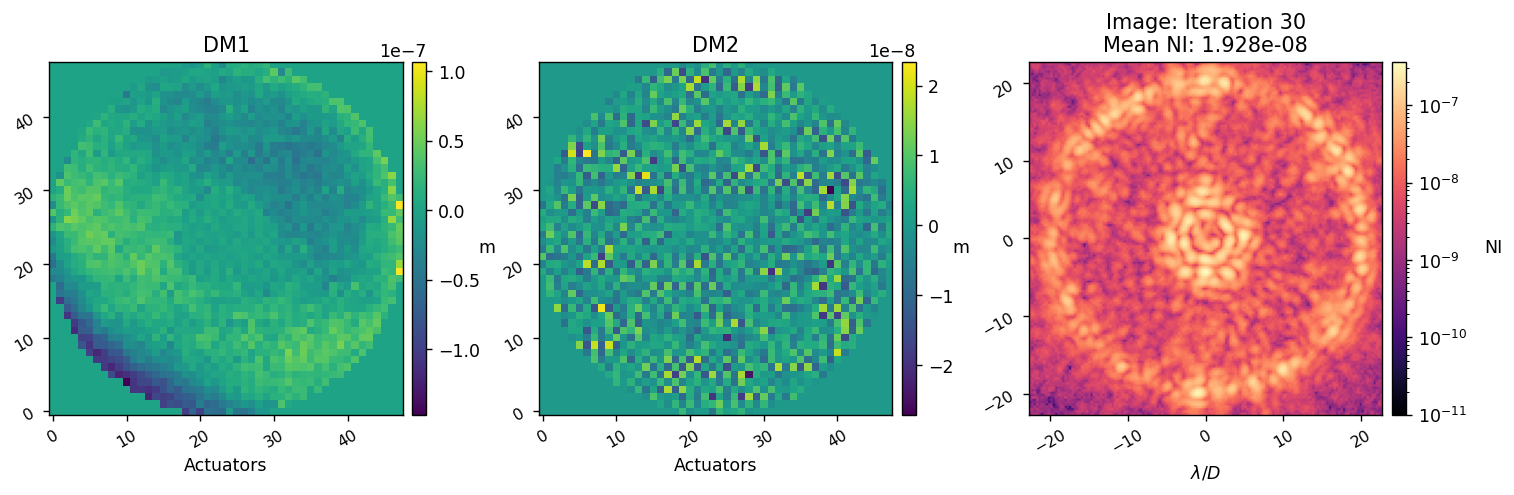

Closed loop for given control matrix completed in 37.389s.


In [109]:
reload(iefc_2dm)
reload(utils)

reg_fun = utils.beta_reg
reg_conds = -2
reg_conds = -2.5
# reg_conds = -3.5
reg_conds = -4
# reg_conds = -4.5
# reg_conds = -5
# reg_conds = -6

images, dm1_commands, dm2_commands, regs = iefc_2dm.run(mode, 
                                                        response_matrix,
                                                        reg_fun, reg_conds, 
                                                        probe_modes, 
                                                        probe_amp, 
                                                        calib_modes,
                                                        control_mask, 
                                                        num_iterations=3, 
                                                        loop_gain=0.5, 
                                                        leakage=0,
                                                        probe_exp_time=probe_exp_times,
                                                        probe_nframes=probe_Nframes,
                                                        probe_em_gain=probe_em_gain,
                                                        metric_exp_time=metric_exp_times,
                                                        metric_nframes=metric_Nframes,
                                                        metric_em_gain=metric_em_gain,
                                                        plot_all=True,
                                                        plot_radial_contrast=False,
                                                        old_images=images,
                                                        old_dm1_commands=dm1_commands,
                                                        old_dm2_commands=dm2_commands,
                                                        old_regs=regs,
                                                        )

In [110]:
utils.save_fits(response_dir/f'spc_wfov_band4_emccd_dm1_commands_2_{today}.fits', dm1_commands)
utils.save_fits(response_dir/f'spc_wfov_band4_emccd_dm2_commands_2_{today}.fits', dm2_commands)
utils.save_fits(response_dir/f'spc_wfov_band4_emccd_images_2_{today}.fits', images)
utils.save_fits(response_dir/f'spc_wfov_band4_emccd_regs_2_{today}.fits', regs)

Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4_emccd_dm1_commands_2_20240213.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4_emccd_dm2_commands_2_20240213.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4_emccd_images_2_20240213.fits
Saved data to:  /home/kianmilani/Projects/roman-cgi-iefc-data/response-data/spc_wfov_band4_emccd_regs_2_20240213.fits
